In [32]:
import warnings
warnings.filterwarnings('ignore')

import random, re, time, xgboost
import numpy as np
from numpy.linalg import svd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency, skew
from sklearn.datasets import load_iris, make_classification, load_breast_cancer, load_boston, make_blobs
from sklearn import datasets, tree

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, PolynomialFeatures

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, confusion_matrix, f1_score, classification_report,\
    precision_recall_curve, roc_auc_score, mean_squared_error, r2_score,\
    mean_absolute_error, silhouette_samples, silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import plot_importance, XGBClassifier, XGBRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

## 군집
* 각 군집화 기법은 나름의 장단점을 가지고 있으며 군집화하려는 데이터의 특성에 맞게 수행해야 함
* K-평균의 경우 거리 기반으로 군집 중심점을 이동시키면서 군집화를 수행. 매우 직관적인 알고리즘으로 많은 군집화 애플리케이션에 애용되지만 복잡한 구조를 가지는 데이터세트에 적용하기에는 한계가 있음. 평가는 실루엣 계수를 이용
* 평균이동(Mean Shift)은 K-평균과 유사하나 거리 중심이 아니고 데이터가 모여있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화를 수행. 컴퓨터 비전 영역에서 이미지나 영상 데이터의 특정 개체 구분에 적합한 알고리즘
* GMM(Gausian Mixture Model)은 군집화를 적용하고자 하는 데이터를 여러 개의 가우시안 분포 모델을 섞어서 생성된 모델로 가정해 수행하는 방식. K-평균 보다 유연하고 다양한 데이터 세트에 잘 적용될 수 있으나 수행 시간이 오래 걸림
* DBSCAN(Density Based Spatial Clustering of Applications with Noise)은 밀도 기반 군집화의 대표적인 알고리즘으로 데이터의 분포가 기하학적으로 복잡한 데이터 세트에 효과적인 군집화가 가능함
- 비지도 학습 -> 평가가 어려움(검증셋이 없으니까) -> 완벽하지는 않아도, 평가를 위해 실루엣 계수가 있음

In [3]:
iris = load_iris()
irisdf = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width','petal_length','petal_width'])
irisdf.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(irisdf)

KMeans(n_clusters=3, random_state=0)

In [5]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [6]:
irisdf['target'] = iris.target
irisdf['cluster'] = kmeans.labels_

iris_result = irisdf.groupby(['target','cluster'])['sepal_length'].count()

In [7]:
irisdf.groupby(['target','cluster']).agg({'sepal_length':'count'})   #iris_result

sepal_length
target cluster              
0      1                  50
1      0                  48
       2                   2
2      0                  14
       2                  36

In [8]:
irisdf.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target,cluster
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

irisdf['pca_x'] = pca_transformed[:,0]
irisdf['pca_y'] = pca_transformed[:,1]
irisdf.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,1,-2.888991,-0.144949


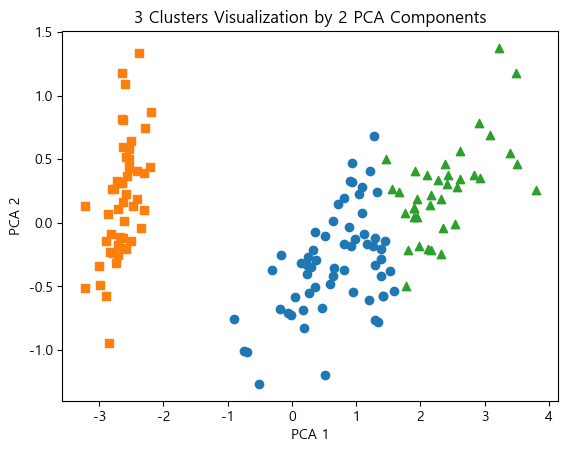

In [10]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = irisdf[irisdf['cluster']==0].index
marker1_ind = irisdf[irisdf['cluster']==1].index
marker2_ind = irisdf[irisdf['cluster']==2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=irisdf.loc[marker0_ind, 'pca_x'], y=irisdf.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=irisdf.loc[marker1_ind, 'pca_x'], y=irisdf.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=irisdf.loc[marker2_ind, 'pca_x'], y=irisdf.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

### Clustering 알고리즘 테스트를 위한 데이터 생성

In [11]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)
print(x.shape, y.shape)

unique, counts = np.unique(y, return_counts=True)
print(unique, counts)  # y타겟값의 분포를 확인

(200, 2) (200,)
[0 1 2] [67 67 66]


In [12]:
clusterdf = pd.DataFrame(data=x, columns=['ftr1','ftr2'])
clusterdf['target'] = y
clusterdf.head(3)

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0


[0 1 2]


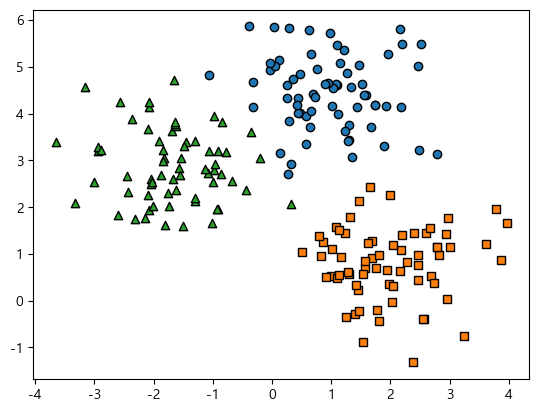

In [13]:
target_list = np.unique(y)
print(target_list)

markers=['o','s','^']    # 각 타깃별 산점도의 마커 값
# 3개 군집영역으로 구분한 데이터셋을 생성했으므로 target_list = [0,1,2]
# target==n 으로 스캐터플랏을 marker별로 생성
for t in target_list:
    target_cluster = clusterdf[clusterdf['target']==t]
    plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'],
                edgecolor='k', marker=markers[t])
plt.show()

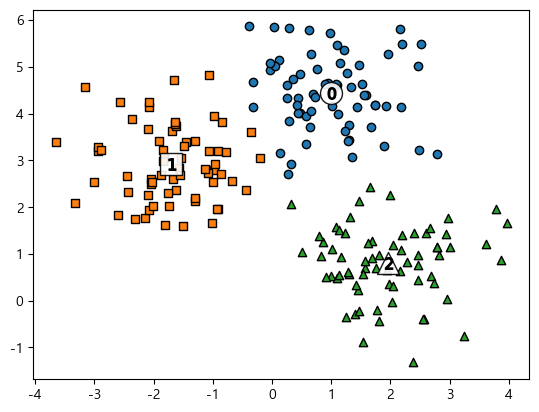

In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=200, random_state=0)   #객체 생성
cluster_labels = kmeans.fit_predict(x)   # k-means클러스터링 수행

clusterdf['kmeans_label'] = cluster_labels

# cluster_centers_: 개별 클러스터의 중심위치 좌표 시각화를 위해 추출
centers = kmeans.cluster_centers_   #클러스터의 중심 위치 저장
unique_labels = np.unique(cluster_labels)
markers=['o','s','^','P','D','H','x']

for la in unique_labels:  # 군집된 유형별로 반복하며, 마커별 스캐터플랏 수행
    label_cluster = clusterdf[clusterdf['kmeans_label']==la]
    center_xy = centers[la]
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], 
                edgecolor='k', marker=markers[la])
    
    # 군집별 중심 위치 좌표 시각화 (배경, 숫자)
    plt.scatter(x=center_xy[0], y=center_xy[1], s=250, color='white',
               alpha=0.9, edgecolor='k', marker=markers[la])
    plt.scatter(x=center_xy[0], y=center_xy[1], s=70, color='k',
               edgecolor='k', marker=f'${la}$')

In [15]:
clusterdf.groupby(['target','kmeans_label']).agg({'kmeans_label':'count'})
# kmeans_label 개수

kmeans_label
target kmeans_label              
0      0                       66
       1                        1
1      2                       67
2      1                       65
       2                        1

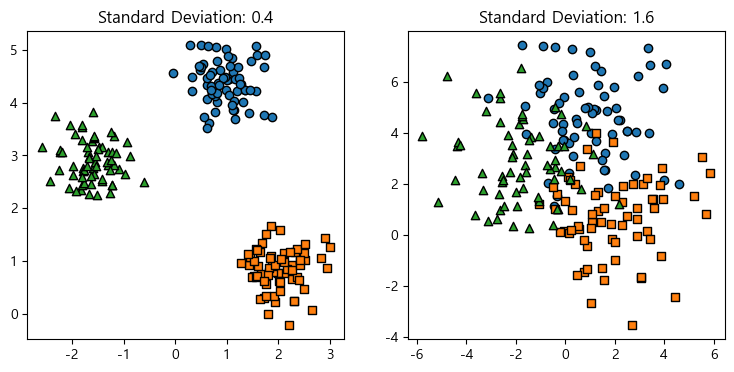

In [16]:
#cluster_std를 0.4와 1.6으로 고쳐가며 군집화 보기
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)

for i, std in zip([ax1, ax2], [0.4, 1.6]):
    x, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=std, random_state=0)
    unique, counts = np.unique(y, return_counts=True)

    clusterdf = pd.DataFrame(data=x, columns=['ftr1','ftr2'])
    clusterdf['target'] = y

    target_list = np.unique(y)

    markers=['o','s','^']
    for t in target_list:
        target_cluster = clusterdf[clusterdf['target']==t]
        i.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'],
                    edgecolor='k', marker=markers[t])
        i.set_title(f'Standard Deviation: {std}')
plt.show()

#### 과제[1]: make_blob을 이용하여 새로운 데이터셋을 만들고 k-means 군집분석을 수행하고 시각화하세요

In [17]:
# n_samples: 생성할 데이터 총 개수, n_features: 특성(칼럼) 개수
# centers: 생성할 클러스터 개수, cluster_std: 클러스터 내 표준편차
data, y = make_blobs(n_samples=1000, n_features=4, centers=3, cluster_std=1.5, random_state=0)
data = data+np.random.randn()
df = pd.DataFrame(data, columns=['feature1','feature2','feature3','feature4'])
df['target'] = y

value, counts = np.unique(y, return_counts=True)   #return_counts=True: 각 고유값에 따른 개수도 반환
print(value, counts)

df.head(3)

[0 1 2] [334 333 333]


,feature1,feature2,feature3,feature4,target
0,-1.086942,0.818723,-2.442820,9.712654,1
1,1.679233,5.830673,2.436614,3.466594,0
2,-1.489650,3.939604,0.666995,1.432945,0


In [18]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)   #객체 생성
labels = kmeans.fit_predict(df[['feature1','feature3','target']])
#kmeans클러스터링 수행 -> 특성 일부만 선택해서 반영

df['kmeans_label'] = labels
df.head()

,feature1,feature2,feature3,feature4,target,kmeans_label
0,-1.086942,0.818723,-2.442820,9.712654,1,2
1,1.679233,5.830673,2.436614,3.466594,0,0
2,-1.489650,3.939604,0.666995,1.432945,0,2
3,0.291764,1.051483,-2.606061,6.900107,1,2
4,0.401050,1.834003,1.572439,-0.289648,0,0


In [19]:
df.groupby(['target','kmeans_label']).agg({'kmeans_label':'count'})

kmeans_label
target kmeans_label              
0      0                      306
       2                       28
1      0                       15
       2                      318
2      1                      333

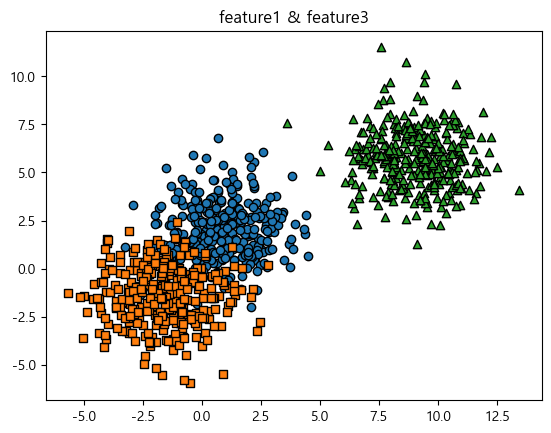

In [20]:
markers=['o','s','^']
for target in value:   #value = 타겟 리스트
    target_cluster = df[df['target']==target]
    plt.scatter(x=target_cluster['feature1'], y=target_cluster['feature3'],
                edgecolor='k', marker=markers[target])
    plt.title(f'feature1 & feature3')

### 클러스터 평가: 실루엣 계수

- 실루엣 계수: 해당 데이터 포인트가 자신이 속한 클러스터와 얼마나 유사하고, 타 클러스터와 얼마나 잘 구분되는지를 평가 (0~1 사이의 값/ 1에 가까울 수록 좋음)
- 전체 실루엣 계수가 높으면서 각 클러스터의 실루엣 계수가 잘 분배되어 있는 것이 좋은 형태

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

iris = load_iris()
irisdf = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width','petal_length','petal_width'])
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(irisdf)

irisdf['cluster'] = kmeans.labels_

# iris의 모든 개별 데이터의 실루엣 계수값을 구함
score_samples = silhouette_samples(iris.data, irisdf['cluster'])
print(f'silhouette_samples() return값의 shape: {score_samples.shape}')

# 데이터프레임에 실루엣 계수 컬럼 추가
irisdf['silhouette_coeff'] = score_samples

# 모든 데이터 평균 실루엣 계수값
avg_score = silhouette_score(iris.data, irisdf['cluster'])
print(f'붓꽃 데이터셋 Silhouette Analysis Score: {avg_score:.3f}')

irisdf.head(3)

silhouette_samples() return값의 shape: (150,)
붓꽃 데이터셋 Silhouette Analysis Score: 0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315


In [26]:
irisdf[['cluster','silhouette_coeff']]

# 각 군집별 실루엣 계수 평균
irisdf.groupby(['cluster']).agg({'silhouette_coeff':'mean'})
# 1번만 너무 높고, 0과 2는 낮음 -> 좋지 않은 분포

,silhouette_coeff
cluster,
0,0.417320
1,0.798140
2,0.451105


In [27]:
### 시각화 함수

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

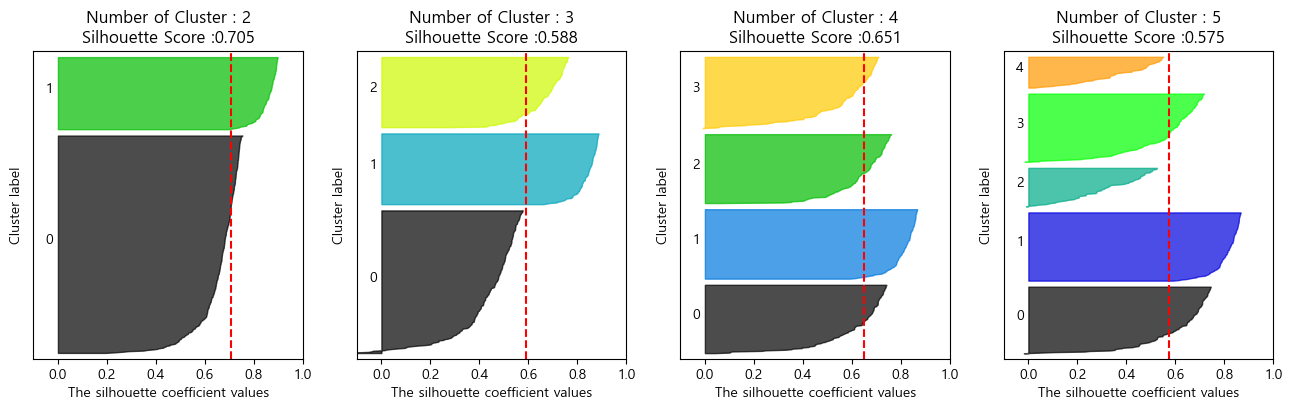

In [28]:
x,y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1,
                center_box=(-10.0, 10.0), shuffle=True, random_state=1)
visualize_silhouette([2,3,4,5], x)   # 시각화 함수

# 전체 실루엣 계수가 높은게 좋음
# 골고루 분포되어 있는게 좋음
# -> 현재 그래프 중에는 3번(클러스터=4)이 좋음(골고루 분포, 평균 높은 편)

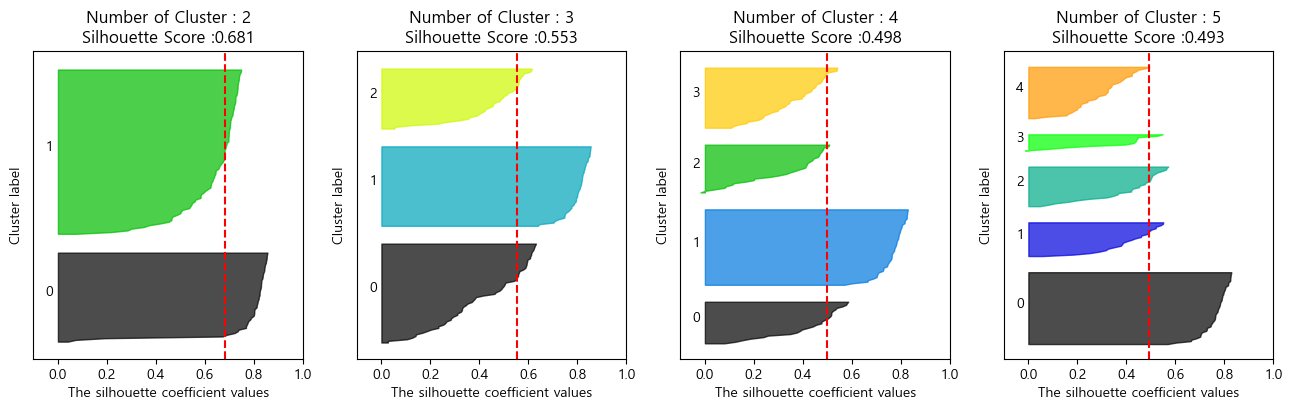

In [29]:
iris = load_iris()
visualize_silhouette([2,3,4,5], iris.data)
# 전체 실루엣 계수나, 각 군집의 계수를 봤을 때
# 1번 그래프(클러스터=2)가 좋음

In [1]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

### 교재 코드
### K-Means를 이용한 붓꽃(Iris) 데이터 셋 Clustering

In [ ]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
# 보다 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])
irisDF.head(3)

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(irisDF)

In [ ]:
print(kmeans.labels_)

In [ ]:
irisDF['target'] = iris.target
irisDF['cluster']=kmeans.labels_
iris_result = irisDF.groupby(['target','cluster'])['sepal_length'].count()
print(iris_result)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

irisDF['pca_x'] = pca_transformed[:,0]
irisDF['pca_y'] = pca_transformed[:,1]
irisDF.head(3)

In [ ]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = irisDF[irisDF['cluster']==0].index
marker1_ind = irisDF[irisDF['cluster']==1].index
marker2_ind = irisDF[irisDF['cluster']==2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=irisDF.loc[marker0_ind, 'pca_x'], y=irisDF.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=irisDF.loc[marker1_ind, 'pca_x'], y=irisDF.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=irisDF.loc[marker2_ind, 'pca_x'], y=irisDF.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

### Clustering 알고리즘 테스트를 위한 데이터 생성 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
%matplotlib inline

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)
print(X.shape, y.shape)

# y target 값의 분포를 확인
unique, counts = np.unique(y, return_counts=True)
print(unique,counts)

In [ ]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
clusterDF.head(3)

In [ ]:
target_list = np.unique(y)
# 각 타깃별 산점도의 마커 값.
markers=['o', 's', '^', 'P', 'D', 'H', 'x']
# 3개의 군집 영역으로 구분한 데이터 세트를 생성했으므로 target_list는 [0, 1, 2]
# target==0, target==1, target==2 로 scatter plot을 marker별로 생성.
for target in target_list:
    target_cluster = clusterDF[clusterDF['target']==target]
    plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='k',
                marker=markers[target] )

plt.show()

In [ ]:
# KMeans 객체를 이용하여 X 데이터를 K-Means 클러스터링 수행 
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=200, random_state=0)
cluster_labels = kmeans.fit_predict(X)
clusterDF['kmeans_label']  = cluster_labels

#cluster_centers_ 는 개별 클러스터의 중심 위치 좌표 시각화를 위해 추출
centers = kmeans.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'P','D','H','x']

# 군집된 label 유형별로 iteration 하면서 marker 별로 scatter plot 수행. 
for label in unique_labels:
    label_cluster = clusterDF[clusterDF['kmeans_label']==label]
    center_x_y = centers[label]
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    # 군집별 중심 위치 좌표 시각화 
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                alpha=0.9, edgecolor='k', marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)

plt.show()


In [ ]:
print(clusterDF.groupby('target')['kmeans_label'].value_counts())